## Mathematical Principles in Pattern Recognition (2017/2018)
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bA}{\mathbf{A}}$
$\newcommand{\bQ}{\mathbf{Q}}$
$\newcommand{\bR}{\mathbf{R}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bSigma}{\boldsymbol{\Sigma}}$
$\newcommand{\bmu}{\boldsymbol{\mu}}$
$\newcommand{\bpi}{\boldsymbol{\pi}}$

# Lab 3

In the computer labs we will work with the Python programming language within a Jupyter notebook. Each week a new notebook is made available that contains the exercises that are to be handed-in. 

* It is expected that you work in pairs but individual submissions are allowed.
* Only one of each pair has to submit on blackboard. Make sure that you add the student ID of your partner in the submission comments.
* The main notebook file you submit should read "Lab[number]_[last name 1]_[last name 2].ipynb", for example "Lab2_Bongers_Versteeg.ipynb". 
* Please make sure your code will run without problems!

Feel free ask any questions during the computer lab sessions, or email the TA, Elise (e.e.vanderpol@uva.nl).

**The due date for the labs is Friday, Sep 29 at 15:00**

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1 Maximum likelihood estimation
In this exercise, our goal is to use maximum likelihood estimation with gradient descent to estimate the probability density by using of a set of  samples drawn from a multivariate Gaussian. 

Note: even though there exists a close form solution for this case, we will go the academic route and use numerical optimization anyway.

### 1.1 Multivariate Gaussian
**[5 points]** Draw 250 samples from a multivariate Gaussian with parameters
$$
\bmu =
\begin{pmatrix}
        0.3 \\
        -1.8 \\
\end{pmatrix}\mathrm{;\ }
\bSigma =
\begin{pmatrix}
        2.1 & 1.3 \\
        1.3 & 4.9 \\
\end{pmatrix}\mathrm{;\ }
$$
and make a scatterplot of the result.

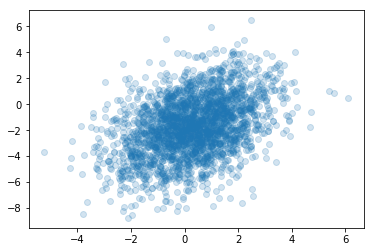

In [173]:
mu = array([0.3, -1.8])
sigma = array([[2.1, 1.3], [1.3, 4.9]])

data = multivariate_normal(mu, sigma, size=2500)
# print(data)

plt.scatter(data[:, 0], data[:, 1], alpha=.2)

### 1.2 Log likelihood
**[15 points]** Write down the log likelihood of this two-dimensional Gaussian model and write a function `loglik(data, mu, sigma)` that returns the log likelihood for the data that it is given. (We will use this later.)

[your answer here]

### 1.3 Gradients
**[15 points]** Write down the gradient of the log likelihood with respect to $\boldsymbol{\mu}$, we already provided the gradient w.r.t. $\bSigma$ below:
$$
\nabla_{\bSigma} (\log \mathcal{L}) = - \frac{n}{2} \bSigma^{-1} + \frac{n}{2} \bSigma^{-1} \boldsymbol{S} \bSigma^{-1}\mathrm{,}
$$
where $\boldsymbol{S} = \frac{1}{n} \sum_i^n (\bx_i- \bmu)(\bx_i- \bmu)^T$. (if you like to derive it as an exercise, feel free to do so.)

Write a function `grad_loglik(x, mu, sigma)` that returns the gradients as evaluated on the data set `x`. 

[your answer here]

### 1.4 Numerical optimization
**[35 points]** Numerically compute maximum likelihood estimates of all parameters. Implement the gradient ascent (or descent, https://en.wikipedia.org/wiki/Gradient_descent) numerical optimization method, by using the functions you created in 1.2 and 1.3. I.e. after initializing all parameters to reasonable values, repeat:
* calculate gradients for the data 
* update the parameters with the gradients and an appropriate learning rate

Keep track of the log likelihood after each step and make a plot of this. 
Run it for several iterations and visualize the resulting distribution with the data in the same figures (either 2 1D projections or a fancy 2D plot is accepted)

## 2. Nonparametric density estimation
Up to now we have used parametric models for (density) estimation. One example of a nonparametric method we used earlier is the (normalized) histogram method, with fixed binning. We will explore an example of a  nonparametric method: kernel density estimation.

Consider the data loaded below, which is drawn from a mixture of 3 Gaussians.

In [3]:
import cPickle
with open('mixture.pkl', 'r') as f:
    mixed_data = cPickle.load(f)
_ = plt.hist(mixed_data, 200)

ImportError: No module named 'cPickle'

### 2.1 Histograms

**[10 points]** Using the `mixed_data` above, illustrate two potential disadvantages of the histogram method as a nonparametric method for density estimation.

### 2.2 Kernel density approximation
**[20 points]** One other way to estimate the density given some data sample, is by using kernels. A kernel $f_h(x)$ is a function of the data, given some smoothing parameter $h$, that specifies the local neighbourhood around a point. (See Bishop 2.5.2 or Hastie 2.8.2 or Google). 

Specify pros and cons of KDE over the histogram method by creating plots of the `mixed_data` above. Use in your arguments one or two different kernels with one or two different bandwidths. You are allowed to use a KDE code from whatever python package you prefer, for example `sklearn` or `statsmodels`.